In [1]:
import pandas as pd
import sqlite3

In [2]:
con = sqlite3.connect('../data/checking-logs.sqlite.sqlite')

In [3]:
views = pd.io.sql.read_sql('''SELECT uid, datetime 
                        FROM pageviews
                        WHERE uid LIKE "user_%"''', con, 
                        parse_dates=['datetime'])

views.head()

,uid,datetime
0,user_30,2020-04-17 22:46:26.785035
1,user_14,2020-04-18 10:53:52.623447
2,user_17,2020-04-18 10:56:55.833899
3,user_14,2020-04-18 10:57:37.331258
4,user_17,2020-04-18 12:05:48.200144


## analyze only the users and not the admins

In [4]:
commits = pd.io.sql.read_sql('''SELECT uid, timestamp 
                        FROM checker
                        WHERE uid LIKE "user_%"''', con, 
                        parse_dates=['timestamp'])

commits.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


##  analyze only the dates when there were both the views and the checker commits

In [5]:
views_group = views.groupby(by=views['datetime'].dt.date)['uid'].count().reset_index()
views_group.columns = ['date', 'views']
views_group.set_index('date', inplace = True)
views_group.head()

,views
date,
2020-04-17,1
2020-04-18,23
2020-04-19,15
2020-04-21,3
2020-04-22,1


In [6]:
commits_group = commits.groupby(by=commits['timestamp'].dt.date)['uid'].count().reset_index()
commits_group.columns = ['date', 'commits']
commits_group.set_index('date', inplace = True)
commits_group.head()

,commits
date,
2020-04-17,23
2020-04-18,69
2020-04-19,33
2020-04-20,25
2020-04-21,25


In [7]:
len(views_group), len(commits_group)

(33, 35)

In [8]:
res = views_group.merge(commits_group, 
                          how='inner', 
                          left_on=views_group.index, 
                          right_on=commits_group.index).set_index('key_0')

In [9]:
res.index.rename('date', inplace=True)

In [10]:
res.head()

,views,commits
date,,
2020-04-17,1,23
2020-04-18,23,69
2020-04-19,15,33
2020-04-21,3,25
2020-04-22,1,28


## use the size of the font should be equal 8, 
## the size of the figure is (15,8)

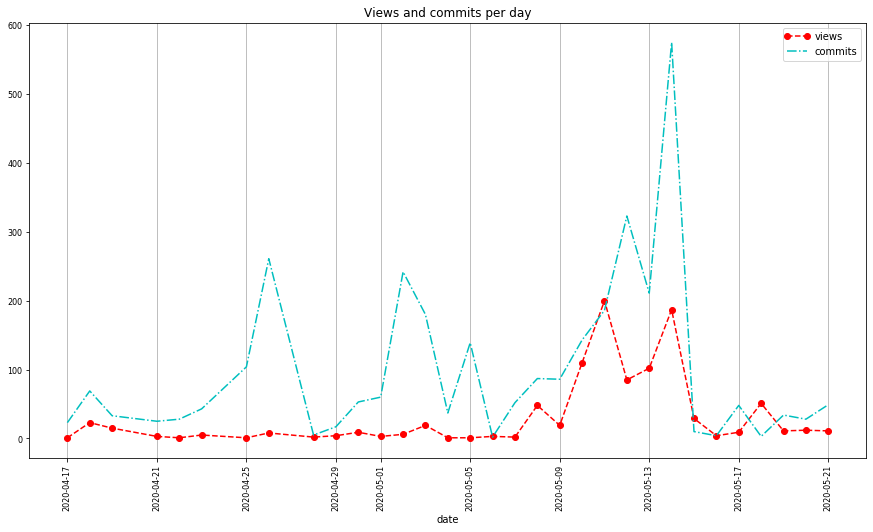

In [11]:
ax = res.plot(fontsize=8, 
         figsize=(15,8), 
         title='Views and commits per day',
        color=['red', 'c'], style=['--', '-.'], rot=90)
ax.grid(axis='x')
ax.get_lines()[0].set_marker('o')
ax.get_legend().get_lines()[0].set_marker('o')

## How many times the number of the views was larger than 150?

In [12]:
print('The answer is', res[res['views'] > 150]['views'].count())

The answer is 2


In [13]:
con.close()